- Classify Audio Sound Bird CLEF 2023 Using YAMNET Model

In [1]:
%%time

import warnings
warnings.filterwarnings('ignore')

CPU times: user 22 µs, sys: 8 µs, total: 30 µs
Wall time: 36.5 µs


In [2]:
%%time

import tensorflow as tf
import tensorflow_hub as hub

# Load the YAMNet model from TensorFlow Hub
yamnet_model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

CPU times: user 7.26 s, sys: 1.3 s, total: 8.56 s
Wall time: 12.6 s


Processing audio files...
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC247367.ogg - Class: Animal - Confidence: 0.270
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC574558.ogg - Class: Animal - Confidence: 0.373
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC403259.ogg - Class: Animal - Confidence: 0.153
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC498854.ogg - Class: Insect - Confidence: 0.648
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC289493.ogg - Class: Frog - Confidence: 0.766
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC716763.ogg - Class: Animal - Confidence: 0.493
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC498853.ogg - Class: Insect - Confidence: 0.618
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC338717.ogg - Class: Silence - Confidence: 0.476
Processed: /kaggle/input/birdclef-2023/train_audio/yetgre1/XC349660.ogg - Class: Cricket - Confidence: 0.615
Pr

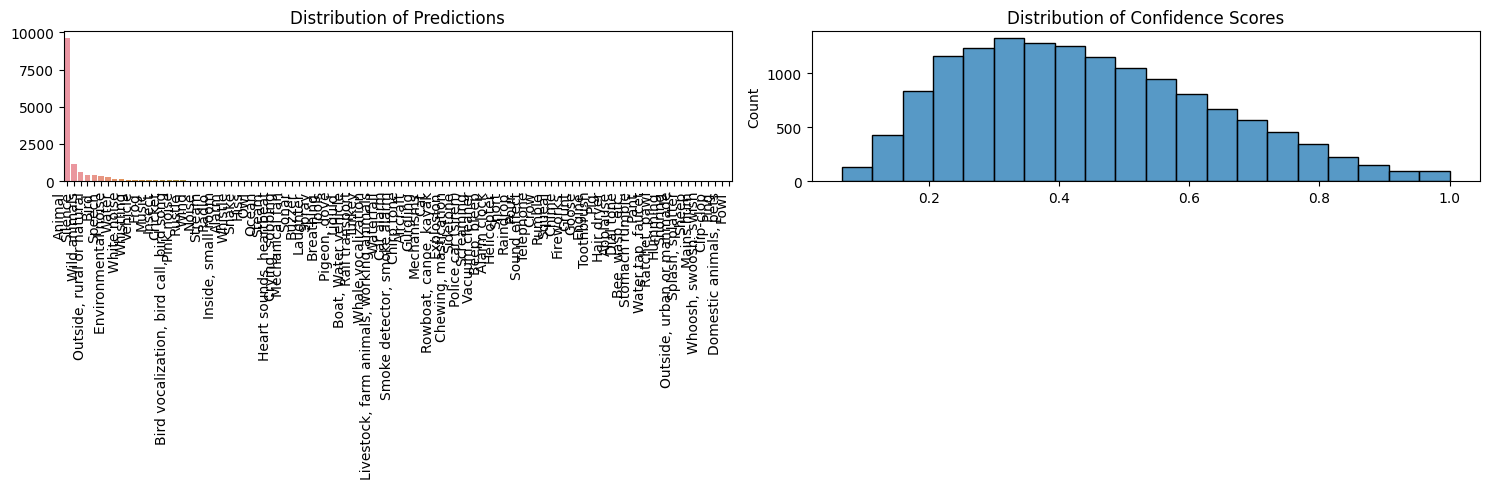

Filtered results saved to trained_all_data_sound_bird_clef_2023.csv
CPU times: user 30min 14s, sys: 31.9 s, total: 30min 45s
Wall time: 33min 17s


In [3]:
%%time

import os
import librosa
import numpy as np
import soundfile as sf  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import io
import csv

# Function to extract class names from the model's class_map_path
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_map_csv = io.StringIO(class_map_csv_text)
    # Skip the header
    csv_reader = csv.reader(class_map_csv)
    next(csv_reader)
    class_names = [display_name for (class_index, mid, display_name) in csv_reader]
    return class_names

# Load class names from the model's class_map_path
class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

def preprocess_audio(audio_file_path, target_sr=22050):
    """Preprocess audio file for YAMNet input."""
    try:
        # Load and resample audio 
        waveform, sr = librosa.load(audio_file_path, sr=target_sr)
        
        # Ensure minimum duration (1 second)
        if len(waveform) < target_sr:
            waveform = np.pad(waveform, (0, target_sr - len(waveform)))
        
        return waveform
        
    except Exception as e:
        print(f"Error processing {audio_file_path}: {str(e)}")
        return None

def classify_audio_file(audio_file_path):
    """Classify audio file using YAMNet."""
    try:
        # Preprocess audio
        waveform = preprocess_audio(audio_file_path, target_sr=22050)  # YAMNet expects 16kHz
        if waveform is None:
            return None, None
        
        # Run the model
        scores, embeddings, spectrogram = yamnet_model(waveform)
        
        # Get the predicted class and confidence
        class_scores = scores.numpy().mean(axis=0)
        predicted_class_idx = np.argmax(class_scores)
        confidence_score = class_scores[predicted_class_idx]
        
        # Get class name from the loaded class names
        predicted_class = class_names[predicted_class_idx]
        
        return predicted_class, confidence_score
        
    except Exception as e:
        print(f"Error classifying {audio_file_path}: {str(e)}")
        return None, None

def process_audio_directory(audio_directory, limit=75):
    """Process all audio files in a directory and its subdirectories."""
    results = []
    
    # Traverse through the directory and its subdirectories
    for dirpath, _, filenames in os.walk(audio_directory):
        # Get all audio files ending with .ogg format
        audio_files = [f for f in filenames if f.lower().endswith('.ogg')][:limit]
        
        for audio_file in audio_files:
            audio_file_path = os.path.join(dirpath, audio_file)
            predicted_class, confidence = classify_audio_file(audio_file_path)
            
            if predicted_class is not None:
                results.append((audio_file_path, predicted_class, confidence))
                print(f"Processed: {audio_file_path} - Class: {predicted_class} - Confidence: {confidence:.3f}")
    
    return results

def plot_results(results):
    """Plot classification results."""
    if not results:
        print("No results to plot.")
        return
    
    # Extract predictions and confidences
    predictions = [r[1] for r in results]
    confidences = [r[2] for r in results]
    
    # Plot distribution of predictions
    plt.figure(figsize=(15, 5))
    
    # Prediction distribution
    plt.subplot(1, 2, 1)
    pred_counts = pd.Series(predictions).value_counts()
    sns.barplot(x=pred_counts.index, y=pred_counts.values)
    plt.xticks(rotation=90, ha='right')
    plt.title('Distribution of Predictions')
    
    # Confidence distribution
    plt.subplot(1, 2, 2)
    sns.histplot(confidences, bins=20)
    plt.title('Distribution of Confidence Scores')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Directory containing the audio files
    audio_directory = '/kaggle/input/birdclef-2023/train_audio/'
    
    # Process audio files
    print("Processing audio files...")
    results = process_audio_directory(audio_directory, limit=234)
    
    # Create DataFrame 
    if results:
        df_results = pd.DataFrame(results, columns=['filename', 'prediction', 'confidence'])
    
        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        print(f"Total files processed: {len(df_results)}")
        print("\nPrediction counts:")
        print(df_results['prediction'].value_counts().head())
        print("\nConfidence score statistics:")
        print(df_results['confidence'].describe())
        
        # Plot results
        plot_results(results)
        
        # Save results all confidence scores
        df_filtered = df_results[df_results['confidence'] >= 0.1]
        
        # Save the filtered DataFrame to a CSV file
        output_csv_path = 'trained_all_data_sound_bird_clef_2023.csv'
        df_filtered.to_csv(output_csv_path, index=False)
        print(f"Filtered results saved to {output_csv_path}")
        
    else:
        print("No audio files processed successfully.")